# РЕКОМЕНДАЦИЯ ТАРИФОВ

## Описание задачи

### Постановка задачи

Заказчиком выступает Оператор мобильной связи «Мегалайн». Многие клиенты пользуются архивными тарифами. Заказчик предоставил данные о поведении клиентов, которые уже перешли на эти тарифы. 

**Описание модели:**
1. Модель должна проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
2. Значение *accuracy* необходимо довести хотя бы до 0.75. 

### Ход исполнения

1. Разделим исходные данные на обучающую, валидационную и тестовую выборки.
2. Исследуем качество разных моделей, меняя гиперпараметры. Кратко опишем выводы исследования.
3. Проверим качество модели на тестовой выборке.
4. Проверим модели на вменяемость.

## Обзор данных

### Загрузка данных

In [1]:
# импортируем необходимые нам библиотеки для работы с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# импорт моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# импорт вспомогательных функций
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In C:\Users\1\anaconda3\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\1\anaconda3\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\1\anaconda3\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\1\anaconda3\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\1\anaconda3\envs\praktikum\lib\site-

In [2]:
# читаем файл и сохраняем в переменные дальнейшей работы, в том числе изменений
# используем оператор обработки исключений, чтобы избежать ошибки, при открытии данных,
# расположенных по другому адресу 
try: 
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('datasets/users_behavior.csv')
    
try: 
    df_control = pd.read_csv('/datasets/users_behavior.csv')
except:
    df_control = pd.read_csv('datasets/users_behavior.csv')

In [3]:
# проверим результат, а также ознакомимся с данными
# используем метод sample() для случайной выборки
# с параметром random_state=1, для сохранения результата 
# при повторных запусках алгоритма

data_list = [df, df_control]

for data in data_list:
    display(data.sample(5, random_state=1))
    print('=' * 45)

,calls,minutes,messages,mb_used,is_ultra
1719,62.0,545.53,3.0,4942.50,0
2922,74.0,498.09,97.0,16471.48,0
1895,93.0,630.74,54.0,13246.51,0
161,58.0,394.15,48.0,15605.44,0
255,40.0,225.89,12.0,13581.94,0


,calls,minutes,messages,mb_used,is_ultra
1719,62.0,545.53,3.0,4942.50,0
2922,74.0,498.09,97.0,16471.48,0
1895,93.0,630.74,54.0,13246.51,0
161,58.0,394.15,48.0,15605.44,0
255,40.0,225.89,12.0,13581.94,0


**Итоги:**

Данные подготовлены надлежащим образом.

### Описание данных

Описание данных предоставлено заказчиком.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [4]:
# изучим данные более внимательно
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Итоги:**

1. В данных отсутствуют пропуски.
2. Данные приведены к подходящему типу.

## Предобработка данных

### Проблемы в данных

In [5]:
# изучим содержание датасета на предмет явных проблем
print('\033[1m' + 'Количество явных дубликатов: ' + '\033[0m', df.duplicated().sum())
print('=' * 45)

n=0
for column in data:
    print('\033[1m' + f'Количество пропусков в столбце {df.columns[n]}:' + '\033[0m', 
              df[column].isna().sum())
    print('=' * 45)
    print()        
    n += 1

Количество явных дубликатов:  0
Количество пропусков в столбце calls: 0

Количество пропусков в столбце minutes: 0

Количество пропусков в столбце messages: 0

Количество пропусков в столбце mb_used: 0

Количество пропусков в столбце is_ultra: 0



### Распределение признаков

Изучим распределения признаков.

In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


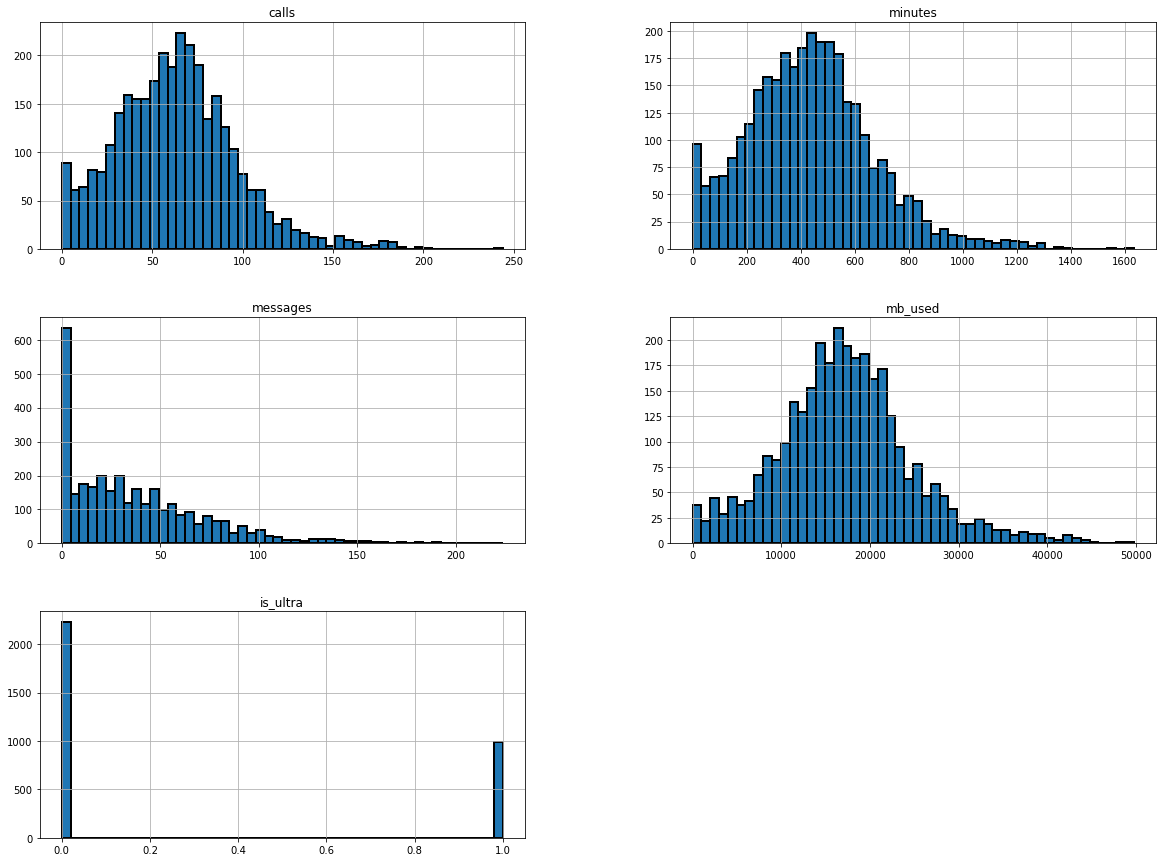

In [7]:
df.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

### Доля целевого признака

Для того, чтобы избежать скошенности при обучении, проверим долю целевого признака в общей выборке. Сохраним эти данные для использования позднее, при формировании выборок.

In [8]:
# напишем функцию, для использования позднее
def target_part (data):
    '''
    Функция высчитывает долю абонентов Ультра в переданном датасете.
    data - переданный датасет;
    column - столбец датасета data, содержащий данные по тарифу.
    '''
    result = round((data.sum() / len(data)) * 100, 2)
    return result

In [9]:
# расчитаем доли целевого признака в основном датасете
result = target_part (df['is_ultra'])
print(f'Доля абонентов тарифа Ультра в общем датасете составляет: {result}%.')

Доля абонентов тарифа Ультра в общем датасете составляет: 30.65%.


**Итоги:**

Пропуски и дубликаты отсутствуют. Данные имеют распределение, близкое к колоколообразному для целей МО.
Данные предоставлены чистыми и обработанными, дополнительной предобработки не требуется.

## Формирование выборок

### Формирование

Извлечем признаки и целевой признак.

In [10]:
# сформируем фильтры
features = ['calls', 'minutes', 'messages', 'mb_used']
target = ['is_ultra']

In [11]:
# подготовим массивы
X = df[features]
y = np.ravel(df[target])

Подготовим выборки. 

In [12]:
# подготовим тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Из выделенного сета подготовим обучающую и валидационную выборки. Итоговый размер выборок составит:
- Тестовая: 20%;
- Валидационная: 20% (0.25 х 0.8 = 0.2);
- Обучающая: 60%.

In [13]:
# подготовим обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Проверим результаты, сравнив длину выборок.

In [14]:
# выведем длину выборок на экран
X_sample_list = [X_train, X_test, X_val]
counter = 0
for sample in X_sample_list:
    print(len(sample)/len(X))
    counter += len(sample)/len(X)

# проверим их сумму
if counter == 1.:
    print('Выборки разбиты надлежащим образом')
else:
    print('Выборки разбиты неправильно!')

0.5998755444928439
0.2000622277535781
0.2000622277535781
Выборки разбиты надлежащим образом


### Проверка долей целевого признака

Проверим выборки на репрезентативность.

In [15]:
y_sample_list = [y_train, y_test, y_val]
y_name_list = ['Обучающий набор', 'Тестовый набор', 'Валидационный набор']
for index, sample in enumerate(y_sample_list):
    print(f'{y_name_list[index]} содержит {target_part(sample)}% абонентов тарифа Ультра.')

Обучающий набор содержит 31.38% абонентов тарифа Ультра.
Тестовый набор содержит 29.24% абонентов тарифа Ультра.
Валидационный набор содержит 29.86% абонентов тарифа Ультра.


**Итоги:**

Подготовлены надлежащие выборки.
Распределение целевого признака сохранено.

## Исследование моделей

Зададим целевую accuracy для сравнения моделей.

In [16]:
target_acc = 0.75

In [17]:
def comparator(model_acc, target_acc=target_acc):
    '''
    Функция сравнивает целевую оценку с оценкой, полученной моделью. 
    target_acc - целевая accuracy, равная по умолчанию 0.75
    model_acc - accuracy обученной модели.
    '''
    if model_acc >= target_acc:
        print('Результат допустимый!')
    else:
        print('Результат провальный, модель НУЖНО настроить!')

In [18]:
# сохраним оценки чистых моделей
pure_acc = []

### Логистическая регрессия

#### Чистая модель

In [19]:
# определим модель
model = LogisticRegression(random_state=42) 

# обучим модель
model.fit(X_train, y_train) 

# предскажем
predict = model.predict(X_val) 

In [20]:
# проверим accuracy чистой модели
print(f'Точность чистой модели: {accuracy_score(y_val, predict)}')
comparator(accuracy_score(y_val, predict))
pure_acc.append(accuracy_score(y_val, predict))

Точность чистой модели: 0.7200622083981337
Результат провальный, модель НУЖНО настроить!


#### Настройка модели

Модель показала недостаточно хороший результат. Настроим следующие гиперпараметры:
- class_weight;
- C - для дополнительного регулирования.

In [21]:
# определим solver подходящий для небольших датасетов
model = LogisticRegression(random_state=42, solver='liblinear') 

In [22]:
# определим грид для настройки
param_grid = [
    {'class_weight': [None, 'balanced'], 'C': [0.5, 1.0, 1.5, 2.0]} 
]

In [23]:
grid_search = GridSearchCV(
    model, param_grid, cv=5, 
    scoring='accuracy', 
    return_train_score=True
)

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid=[{'C': [0.5, 1.0, 1.5, 2.0],
                          'class_weight': [None, 'balanced']}],
             return_train_score=True, scoring='accuracy')

Проверим *accuracy* настроенной модели.

In [25]:
# определим модель
model = grid_search.best_estimator_

# обучим модель
model.fit(X_train, y_train) 

# предскажем
predict = model.predict(X_val) 

In [26]:
# проверим accuracy настроенной модели
print(f'Точность настроенной модели: {accuracy_score(y_val, predict)}')
comparator(accuracy_score(y_val, predict))

Точность настроенной модели: 0.7231726283048211
Результат провальный, модель НУЖНО настроить!


In [27]:
# сохраним модель для дальнейшего использования
LR_model = grid_search.best_estimator_ 

**Итоги:**

Модель демонстрирует невысокие результаты независимо от настроек гиперпараметров.

### Дерево решений

#### Чистая модель

In [28]:
# обучим модель
model = DecisionTreeClassifier(random_state=42) 
model.fit(X_train, y_train) 

# предскажем 
predictions = model.predict(X_val) 

In [29]:
# проверим accuracy чистой модели
print(f'Точность чистой модели: {accuracy_score(y_val, predictions)}')
comparator(accuracy_score(y_val, predictions))
pure_acc.append(accuracy_score(y_val, predictions))

Точность чистой модели: 0.7309486780715396
Результат провальный, модель НУЖНО настроить!


#### Настройка модели

In [30]:
model = DecisionTreeClassifier(random_state=42) 

In [31]:
# определим грид для настройки
param_grid = [
    {'max_depth': range(1, 10), 
     'criterion': ['gini', 'entropy'], 
     'splitter': ['random', 'best'], 
     'min_samples_leaf': range(1, 10)} 
]

In [32]:
grid_search = GridSearchCV(
    model, param_grid, cv=5, 
    scoring='accuracy', 
    return_train_score=True
)

In [33]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': range(1, 10),
                          'min_samples_leaf': range(1, 10),
                          'splitter': ['random', 'best']}],
             return_train_score=True, scoring='accuracy')

Проверим *accuracy* настроенной модели.

In [34]:
# определим модель
model = grid_search.best_estimator_

# обучим модель
model.fit(X_train, y_train) 

# предскажем
predict = model.predict(X_val) 

In [35]:
# проверим accuracy настроенной модели
print(f'Точность настроенной модели: {accuracy_score(y_val, predict)}')
comparator(accuracy_score(y_val, predict))

Точность настроенной модели: 0.7978227060653188
Результат допустимый!


In [36]:
# сохраним модель для дальнейшего использования
DTC_model = grid_search.best_estimator_ 

**Итоги:**

Настроенная модель показала лучший результат почти на 8%.

### Рандомный лес

#### Чистая модель

In [37]:
# обучим модель
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train) 
    
# предскажем
predictions = model.predict(X_val)

In [38]:
# проверим accuracy чистой модели
print(f'Точность чистой модели: {accuracy_score(y_val, predictions)}')
comparator(accuracy_score(y_val, predictions))
pure_acc.append(accuracy_score(y_val, predictions))

Точность чистой модели: 0.7947122861586314
Результат допустимый!


#### Настройка модели

In [39]:
model = RandomForestClassifier(random_state=42)

In [40]:
# определим грид для настройки
param_grid = [
    {'n_estimators': range(50, 200, 50), 
     'criterion': ['gini', 'entropy'], 
     'min_samples_split': range(2, 10), 
     'min_samples_leaf': range(1, 10)} 
]

In [41]:
grid_search = GridSearchCV(
    model, param_grid, cv=5, 
    scoring='accuracy', 
    return_train_score=True
)

In [42]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'min_samples_leaf': range(1, 10),
                          'min_samples_split': range(2, 10),
                          'n_estimators': range(50, 200, 50)}],
             return_train_score=True, scoring='accuracy')

Проверим *accuracy* настроенной модели.

In [43]:
# определим модель
model = grid_search.best_estimator_ 

# обучим модель
model.fit(X_train, y_train) 

# предскажем
predict = model.predict(X_val) 

In [44]:
# проверим accuracy настроенной модели
print(f'Точность настроенной модели: {accuracy_score(y_val, predict)}')
comparator(accuracy_score(y_val, predict))

Точность настроенной модели: 0.7916018662519441
Результат допустимый!


In [45]:
# сохраним модель для дальнейшего использования
RFC_model = grid_search.best_estimator_ 

**Итоги:**

1. Чистая модель RandomForest показывает лучший результат из всех (79%!)
2. Улучшен

## Проверка на тестовой выборке

In [48]:
# сформируем список моделей
model_list = [LR_model, DTC_model, RFC_model]

# соберем в таблицу их показатели
model_name = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']
table_model_accuracy = []

# объединим обучающую и валидационную выборки для финального обучения
X_train_max = pd.concat([X_train, X_val], ignore_index = True)
y_train_max = np.concatenate((y_train, y_val))

In [49]:
# определим функцию проверки
def tariff_oracle(mod):
    '''
    Функция принимает разные модели в параметры, чтобы вывести их accuracy и сравнить с целевым.
    mod - вид модели.
    '''
    mod.fit(X_train_max, y_train_max) 
    predictions = mod.predict(X_test)
    result = accuracy_score(y_test, predictions)
    print(f'Accuracy модели на тестовой выборке: {result:.2}')
    comparator(result)    
    table_model_accuracy.append(result)

In [50]:
# проверим все модели на тестовой выборке
for mod in model_list:
    print(f'Тестируется модель: {mod}')
    tariff_oracle(mod)
    print('=' * 45)
    print()

Тестируется модель: LogisticRegression(random_state=42, solver='liblinear')
Accuracy модели на тестовой выборке: 0.72
Результат провальный, модель НУЖНО настроить!

Тестируется модель: DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=9,
                       random_state=42, splitter='random')
Accuracy модели на тестовой выборке: 0.79
Результат допустимый!

Тестируется модель: RandomForestClassifier(min_samples_leaf=3, min_samples_split=8, n_estimators=50,
                       random_state=42)
Accuracy модели на тестовой выборке: 0.82
Результат допустимый!



In [52]:
# сформируем сводную таблицу 
table_of_models = pd.DataFrame(
    {'Model': model_name, 'Accuracy': table_model_accuracy, 
    'Pure_acc': pure_acc}
)               
pd.set_option('max_colwidth', 400)
table_of_models

,Model,Accuracy,Pure_acc
0,LogisticRegression,0.720062,0.720062
1,DecisionTreeClassifier,0.793157,0.730949
2,RandomForestClassifier,0.816485,0.794712


**Итоги:**

1. RandomForest показал лучший результат. Но является самым долгообучаемым и сложно настраиваемым. Кроме того, лес склонен к переобучению.
2. Логистическая регрессия показала худший результат - из-за большого количества параметров с разнообразной корреляцией. Более того, настроенная модель показала чуть худшие результаты на тестовой выборке.
3. Дерево решений - показало результат на 2.3% хуже леса. Если для заказчика быстрота и произодительность моделей в приоритете, то стоит выбрать эту модель.

## Проверка модели на вменяемость

Для проверки на вменяемость, используем случайную модель.

In [53]:
# создадим список стратегий
strategies = ['most_frequent', 'stratified', 'uniform']

# проверим accuracy по всем стратегиям
for strat in strategies:
    dc = DummyClassifier(strategy=strat, random_state=42)
    dc.fit(X_train, y_train)
    predictions = dc.predict(X_test)
    res = round(dc.score(predictions, y_test), 2)
    print('Испытываемая стратегия: ', {strat:res})
    comparator(res)

Испытываемая стратегия:  {'most_frequent': 0.71}
Результат провальный, модель НУЖНО настроить!
Испытываемая стратегия:  {'stratified': 0.56}
Результат провальный, модель НУЖНО настроить!
Испытываемая стратегия:  {'uniform': 0.49}
Результат провальный, модель НУЖНО настроить!


**Итоги:**

1. Все стратегии показали худший результат, чем финалист - RandomForest.
2. При этом даже настроенная Логистическая регрессия показывает худший результат.
3. Дерево решений и Рандомный лес, построенные с помощью МО, демонстрируют большую эффективность и полноту, чем случайные обощения. Поэтому считаем использование МО уместным и подходящим.

## Итоги

In [54]:
display(table_of_models.style.set_caption('Таблица accuracy настроеных моделей'))
print(f'Гиперпараметры лучшей модели: {RFC_model}')

,Model,Accuracy,Pure_acc
0,LogisticRegression,0.720062,0.720062
1,DecisionTreeClassifier,0.793157,0.730949
2,RandomForestClassifier,0.816485,0.794712


Гиперпараметры лучшей модели: RandomForestClassifier(min_samples_leaf=3, min_samples_split=8, n_estimators=50,
                       random_state=42)


При решении задачи классификации пользователей, по предпочитаемым ими тарифам, лучший показатель принадлежит модели RandomForestClassifier. При этом Рандомный лес является самым долгообучаемым и сложно настраиваемым (хотя настроенный Рандомный лес показывает результат всего на 2,3% лучше, чем ненастроенный и, фактически, равен Дереву решений). Кроме того, нужно учитывать, что Рандомный лес склонен к переобучению (при наличии данных такого небольшого объема и сложности).

Логистическая регрессия показала худший результат - из-за большого количества параметров с разнообразной корреляцией. Ее найстройки практически не меняют итоговой оценки правильности.

Дерево решений показало результат на 2,3% хуже Рандомного леса. Если для заказчика быстрота и произодительность моделей в приоритете, то стоит выбрать эту модель.